<a href="https://colab.research.google.com/github/RaniaBouchrara/Stage-Rania/blob/master/Lorenz_d%C3%A9terministe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Simulation de dynamiques (séries temporelles) Lorenz_63 déterministe

In [0]:
import numpy as np

def Lorenz_63(S,t,Pra,r,b,gamma):
    """ Lorenz-63 dynamical model. """
    x_1 = Pra*(S[1]-S[0])-(4/(2*gamma))*S[0];
    x_2 = S[0]*(r-S[2])-S[1]-(4/(2*gamma))*S[1];
    x_3 = S[0]*S[1] - b*S[2]-(8/(2*gamma))*S[2];
    dS  = np.array([x_1,x_2,x_3]);
    return dS

In [0]:
from scipy.integrate import odeint
from scipy.integrate import ode
def generate_data(GD):
    """ Generate the true state, noisy observations and catalog of numerical simulations. """

    # initialization
    class xt:
        values = [];
        time = [];
    class yo:
        values = [];
        time = [];
    class catalog:
        analogs = [];
        successors = [];
        source = [];
        time = [];
    
    # test on parameters
    if GD.dt_states>GD.dt_obs:
        print('Error: GD.dt_obs must be bigger than GD.dt_states');
    if (np.mod(GD.dt_obs,GD.dt_states)!=0):
        print('Error: GD.dt_obs must be a multiple of GD.dt_states');

    # use this to generate the same data for different simulations
    np.random.seed(1);

    # 5 time steps (to be in the attractor space)  
    x0 = np.array([8.0,0.0,30.0]);
    S = odeint(Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    x0 = S[S.shape[0]-1,:];

    # generate true state (xt)
    S = odeint(Lorenz_63,x0,np.arange(0.01,GD.nb_loop_test+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    T_test = S.shape[0];      
    t_xt = np.arange(0,T_test,GD.dt_states);       
    xt.time = t_xt*GD.dt_integration;
    xt.values = S[t_xt,:];
        
    # generate  partial/noisy observations (yo)
    eps = np.random.multivariate_normal(np.zeros(3),GD.sigma2_obs*np.eye(3,3),T_test);
    yo_tmp = S[t_xt,:]+eps[t_xt,:];
    t_yo = np.arange(0,T_test,GD.dt_obs);
    i_t_obs = np.where((np.in1d(t_xt,t_yo))==True)[0];
    yo.values = xt.values*np.nan;
    yo.values[np.ix_(i_t_obs,GD.var_obs)] = yo_tmp[np.ix_(i_t_obs,GD.var_obs)];
    yo.time = xt.time;
       

    #generate catalog
    S =  odeint(Lorenz_63,S[S.shape[0]-1,:],np.arange(0.01,GD.nb_loop_train+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    T_train = S.shape[0];
    eta = np.random.multivariate_normal(np.zeros(3),GD.sigma2_catalog*np.eye(3,3),T_train);
    catalog_tmp = S+eta;
    catalog.analogs = catalog_tmp[0:-GD.dt_states,:];
    catalog.successors = catalog_tmp[GD.dt_states:,:]
    catalog.source = GD.parameters;
  # reinitialize random generator number    
    np.random.seed()

    return catalog, xt, yo;

In [0]:
import sys
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D

In [0]:
### GENERATE SIMULATED DATA (LORENZ-63 MODEL)
class GD:
    model = 'Lorenz_63'
    class parameters:
        Pra = 10.0
        r = 28.0
        b = 8.0/3
        gamma=10.0
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 110.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 0.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)

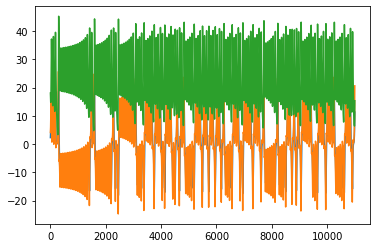

In [0]:
plt.plot(catalog.analogs)

In [0]:
#training data
batch_size = 50
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

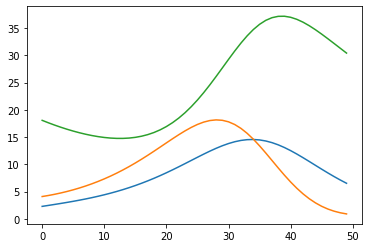

In [0]:
plt.plot(X_train[0,:,:])

In [0]:
params = {}#NN parameters
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_output']=3
params['dim_observations'] = 3
params['dim_hidden']=3
params['ntrain']=[1000,200]
params['dt_integration'] = GD.dt_integration
pretrained = False
path = ''# to be defined
file_name = '' # to be defined

In [0]:
np.random.seed(0)
torch.manual_seed(0)
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_input'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_input'],params['dim_input']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_input'], params['dim_input']) 
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            aug_inp = inp
            BP_outp = (torch.zeros((aug_inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(aug_inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](aug_inp)[:,0]*self.BlinearCell2[i](aug_inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params)

In [0]:
class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k1 = self.Dyn_net(inp,dt)
            inp_k2      = inp + 0.5*params['dt_integration']*k1
            k2     = self.Dyn_net(inp_k2,dt)
            inp_k3      = inp + 0.5*params['dt_integration']*k2       
            k3     = self.Dyn_net(inp_k3,dt)
            inp_k4      = inp + params['dt_integration']*k3          
            k4     = self.Dyn_net(inp_k4,dt)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1

In [0]:
dt = params['dt_integration']
aug_vect = []
x = torch.from_numpy(X_train).float()
y = torch.from_numpy(Y_train).float()
z = torch.from_numpy(Grad_t).float()

modelRINN = INT_net(params)
criterion = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(modelRINN.parameters(),lr = 0.001)

if pretrained :
    modelRINN.load_state_dict(torch.load(path + file_name))

In [0]:
print ('Learning Dynamical model')        
for t in range(params['ntrain'][0]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted y by passing x to the model
        pred, grad = modelRINN(x[b,:,:],params['dt_integration'])
        # Compute and print loss
        loss = criterion(grad, z[b,:,:])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save models
        #torch.save(modelRINN.state_dict(), path + file_name)
    print(t,loss)

Learning Dynamical model


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(2167.7939, grad_fn=<MseLossBackward>)
1 tensor(1198.2391, grad_fn=<MseLossBackward>)
2 tensor(1420.5104, grad_fn=<MseLossBackward>)
3 tensor(1438.4559, grad_fn=<MseLossBackward>)
4 tensor(1158.2848, grad_fn=<MseLossBackward>)
5 tensor(952.7786, grad_fn=<MseLossBackward>)
6 tensor(770.1275, grad_fn=<MseLossBackward>)
7 tensor(600.9072, grad_fn=<MseLossBackward>)
8 tensor(450.3810, grad_fn=<MseLossBackward>)
9 tensor(325.1045, grad_fn=<MseLossBackward>)
10 tensor(228.3890, grad_fn=<MseLossBackward>)
11 tensor(159.1411, grad_fn=<MseLossBackward>)
12 tensor(112.8520, grad_fn=<MseLossBackward>)
13 tensor(83.5495, grad_fn=<MseLossBackward>)
14 tensor(65.5145, grad_fn=<MseLossBackward>)
15 tensor(54.1657, grad_fn=<MseLossBackward>)
16 tensor(46.2266, grad_fn=<MseLossBackward>)
17 tensor(39.5270, grad_fn=<MseLossBackward>)
18 tensor(32.7767, grad_fn=<MseLossBackward>)
19 tensor(25.7187, grad_fn=<MseLossBackward>)
20 tensor(19.9789, grad_fn=<MseLossBackward>)
21 tensor(18.8498, grad_fn

In [0]:
print ('Optimizing flowmap')        
for t in range(params['ntrain'][1]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted y by passing x to the model
        pred, grad = modelRINN(x[b,:,:],params['dt_integration'])
        # Compute and print loss
        loss = criterion(pred, y[b,:,:])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save models
        #torch.save(modelRINN.state_dict(), path + file_name)
    print(t,loss)

Optimizing flowmap


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(2.5281e-05, grad_fn=<MseLossBackward>)
1 tensor(2.3478e-05, grad_fn=<MseLossBackward>)
2 tensor(2.1624e-05, grad_fn=<MseLossBackward>)
3 tensor(1.9733e-05, grad_fn=<MseLossBackward>)
4 tensor(1.7822e-05, grad_fn=<MseLossBackward>)
5 tensor(1.5915e-05, grad_fn=<MseLossBackward>)
6 tensor(1.4044e-05, grad_fn=<MseLossBackward>)
7 tensor(1.2227e-05, grad_fn=<MseLossBackward>)
8 tensor(1.0499e-05, grad_fn=<MseLossBackward>)
9 tensor(8.8794e-06, grad_fn=<MseLossBackward>)
10 tensor(7.3920e-06, grad_fn=<MseLossBackward>)
11 tensor(6.0601e-06, grad_fn=<MseLossBackward>)
12 tensor(4.8939e-06, grad_fn=<MseLossBackward>)
13 tensor(3.8994e-06, grad_fn=<MseLossBackward>)
14 tensor(3.0731e-06, grad_fn=<MseLossBackward>)
15 tensor(2.4058e-06, grad_fn=<MseLossBackward>)
16 tensor(1.8849e-06, grad_fn=<MseLossBackward>)
17 tensor(1.4932e-06, grad_fn=<MseLossBackward>)
18 tensor(1.2154e-06, grad_fn=<MseLossBackward>)
19 tensor(1.0261e-06, grad_fn=<MseLossBackward>)
20 tensor(9.0387e-07, grad_fn=

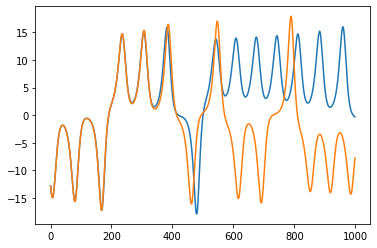

In [0]:
pred = [torch.from_numpy(xt.values[:1,:]).float()]
for i in range(1000):
    pred.append(modelRINN(pred[-1],params['dt_integration'])[0])

plt.plot(torch.stack(pred).data.numpy()[:1000,0,0],label = "Prediction from LQM Dynamical model")
plt.plot(xt.values[:1000,0],label = "True state")